**1) Import Dependencies and mount drive**

In [15]:
# stdlib
import os, re, struct
import glob
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
from PIL import Image
from tqdm import tqdm

# data & imaging
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from PIL import Image
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# torchvision
import torchvision
from torchvision import transforms

# metrics & plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Colab
#from google.colab import drive

In [17]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
# drive.mount('/content/drive', force_remount=True)

# ─── 2) DEVICE & CUDNN ──────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True  # auto‐tune for fixed input sizes

**2. Train Model**
- We can adjust the following
    - Restricting image size: min and max image width used for training and evaluation
    - Stain type
    - Train and test cases

In [149]:
# ─── 1) CONFIG ──────────────────────────────────────────────────────────
image_folder = 'Patches_Apr27'
train_cases  = [2,1,22,9,34,38,53,55,78,62,85,89,21,3,45,49]
test_cases   = [77,60,79,70,90,92,25,12]
train_cases  = [2,1,22,34,53,55,78,62,85,89,21,3,45,49] # Change train cases for ones w/ more patches
test_cases   = [9,38,77,60,79,70,90,92,25,12] # Change test cases for ones w/ more patches
batch_size   = 64
num_workers  = 0
lr           = 1e-3
num_epochs   = 10
stains       = ['h&e']               # adjust list as needed
min_width    = 256
max_width    = 512
meta_csv     = 'patch_metadata.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 2) LABEL CSV & MAP ─────────────────────────────────────────────────
labels_df = pd.read_csv(
    "case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)
class_map = {int(r.Case): (0 if r.Class == 1 else 1) for _, r in labels_df.iterrows()}

# ─── 3) METADATA BUILD/LOAD ──────────────────────────────────────────────
def build_metadata():
    #if os.path.exists(meta_csv):
        #return pd.read_csv(meta_csv)
    # gather all files
    all_files = [os.path.join(dp, f)
                 for dp, _, fs in os.walk(image_folder)
                 for f in fs if f.lower().endswith('.png')]

    def process(p):
        basename = os.path.basename(p)
        cid_m    = re.search(r'case_(\d+)_', basename, re.IGNORECASE)
        if not cid_m:
            return None
        cid = int(cid_m.group(1))
        # case filter
        if cid not in set(train_cases + test_cases):
            return None
        # stain filter
        name_low = basename.lower()
        stain = next((s for s in stains if s in name_low), None)
        if not stain:
            return None
        # header parse
        try:
            with open(p, 'rb') as f:
                hdr = f.read(24)
            w = struct.unpack('>I', hdr[16:20])[0]
            h = struct.unpack('>I', hdr[20:24])[0]
        except:
            return None
        label = class_map.get(cid)
        return {'path': p, 'case_number': cid, 'stain': stain,
                'width': w, 'height': h, 'label': label}

    with ThreadPoolExecutor(max_workers=8) as exe:
        results = list(exe.map(process, all_files))
    df_meta = pd.DataFrame([r for r in results if r])
    df_meta.to_csv(meta_csv, index=False)
    return df_meta

df_meta = build_metadata()

# ─── 4) FILTER FOR TRAIN/TEST ────────────────────────────────────────────
def filter_meta(df, cases):
    df2 = df[df.case_number.isin(cases)]
    df2 = df2[(df2.width > min_width) & (df2.width < max_width)]
    df2 = df2[df2.stain.isin(stains)]
    return df2

df_train = filter_meta(df_meta, train_cases)
df_test  = filter_meta(df_meta, test_cases)

train_labels = df_train['label'].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_paths = df_train['path'].tolist()
test_paths  = df_test['path'].tolist()

# ─── 5) TRANSFORMS & DATASETS ─────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class CaseDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        try:
            img = Image.open(p).convert('RGB')
        except Exception as e:
            print(f"Failed to load image {p}: {e}")
        # You could raise an error, return a dummy image, or skip
        #img = Image.open(p).convert('RGB')
        if self.transform: img = self.transform(img)
        cid = int(re.search(r'case_(\d+)_', os.path.basename(p), re.IGNORECASE).group(1))
        lbl = class_map[cid]
        return img, lbl

train_ds = CaseDataset(train_paths, transform=train_transform)
test_ds  = CaseDataset(test_paths,  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True, persistent_workers=False)

# ─── 6) MODEL SETUP ──────────────────────────────────────────────────────
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters(): param.requires_grad=False
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

# ─── 7) TRAIN LOOP ───────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for imgs, lbls in pbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running += loss.item()*lbls.size(0)
        pbar.set_postfix(loss=running/((pbar.n+1)*batch_size))
    print(f'Epoch {epoch}: Train Loss = {running/len(train_ds):.4f}')

# ─── 8) EVALUATION ───────────────────────────────────────────────────────
model.eval(); correct=total=0
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds==lbls).sum().item(); total += lbls.size(0)
print(f'Test Accuracy: {100*correct/total:.2f}%')

C:\Users\akhil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\akhil\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\akhil\AppData\Local\Temp\ipykernel_3716\2361317006.py:132: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10:   0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\akhil\AppData\Local\Temp\ipykernel_3716\2361317006.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(imgs); loss = criterion(outputs, lbls)


Epoch 1: Train Loss = 0.4283


Epoch 2/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.0988


Epoch 3/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.0674


Epoch 4/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.0510


Epoch 5/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.0522


Epoch 6/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.0383


Epoch 7/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.0348


Epoch 8/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.0427


Epoch 9/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0324


Epoch 10/10:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.0334
Test Accuracy: 54.04%


**3) Evaluate Model**

In [189]:
# Collect model predictions for train and test datasets
model.eval()
all_probs_tr, all_preds_tr, all_labels_tr = [], [], []
all_probs_tst, all_preds_tst, all_labels_tst = [], [], []
correct, total = 0, 0

for images, labels in train_loader:
        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        preds   = outputs.argmax(dim=1)

        all_probs_tr.extend(probs.detach().cpu().numpy())
        all_preds_tr.extend(preds.cpu().numpy())
        all_labels_tr.extend(labels.cpu().numpy())
        #correct += (preds == labels).sum().item()
        #total   += labels.size(0)

for images, labels in test_loader:
        images, labels = (images.to(device, non_blocking=True),
                          labels.to(device, non_blocking=True))
        outputs = model(images)
        probs   = softmax(outputs, dim=1)
        preds   = outputs.argmax(dim=1)

        all_probs_tst.extend(probs.detach().cpu().numpy())
        all_preds_tst.extend(preds.cpu().numpy())
        all_labels_tst.extend(labels.cpu().numpy())
        #correct += (preds == labels).sum().item()
        #total   += labels.size(0)

In [190]:
# Aggregate average probabilities by case
train_prob = [arr[0] for arr in all_probs_tr]
case_prob_train = pd.concat([pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number').mean().reset_index(),df_train.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
test_prob = [arr[0] for arr in all_probs_tst]
case_prob_tst = pd.concat([pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number').mean().reset_index(),df_test.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
case_prob_train

,case_number,prob,label
0,1,0.775633,1.0
1,2,0.831488,0.0
2,3,0.774008,1.0
3,34,0.800082,0.0
4,49,0.994365,1.0
5,53,0.785576,0.0
6,55,0.999075,1.0
7,78,0.993264,0.0
8,85,0.761022,0.0


In [191]:
# Train decision threshold for average probabilities by case
acc, rec, pre, thresh = [], [], [], []
for t in np.arange(0,1,0.01):
    acc.append(accuracy_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    rec.append(recall_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    pre.append(precision_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    thresh.append(t)
print(thresh[acc.index(max(acc))])

0.84


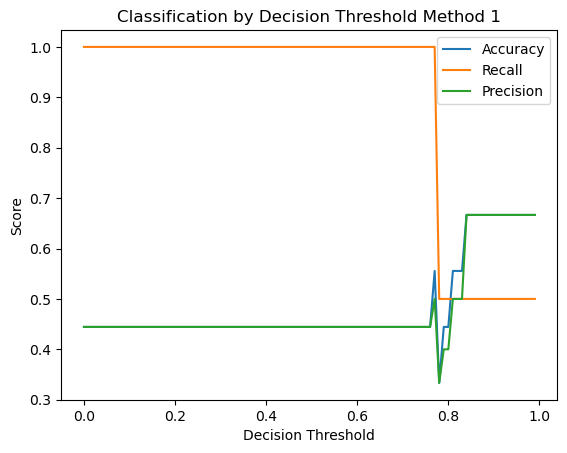

In [192]:
sns.lineplot(x = thresh, y = acc, label = 'Accuracy')
sns.lineplot(x = thresh, y = rec, label = 'Recall')
sns.lineplot(x = thresh, y = pre, label = 'Precision')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Classification by Decision Threshold Method 1')
plt.show()

In [199]:
print(accuracy_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int)))

0.16666666666666666


In [211]:
# Find max probabilities by case
train_prob = [arr[0] for arr in all_probs_tr]
case_prob_train = pd.concat([pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number').max().reset_index(),df_train.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
test_prob = [arr[0] for arr in all_probs_tst]
case_prob_tst = pd.concat([pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number').max().reset_index(),df_test.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
case_prob_train

,case_number,prob,label
0,1,0.999995,1.0
1,2,0.999997,0.0
2,3,0.999990,1.0
3,34,0.999998,0.0
4,49,0.998210,1.0
5,53,1.000000,0.0
6,55,0.999362,1.0
7,78,0.999975,0.0
8,85,0.999998,0.0


In [213]:
# Train decision threshold for max probabilities by case
acc, rec, pre, thresh = [], [], [], []
for t in np.arange(0.999,1,0.000001):
    acc.append(accuracy_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    rec.append(recall_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    pre.append(precision_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    thresh.append(t)
print(thresh[acc.index(max(acc))])

1.0000000000000289


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


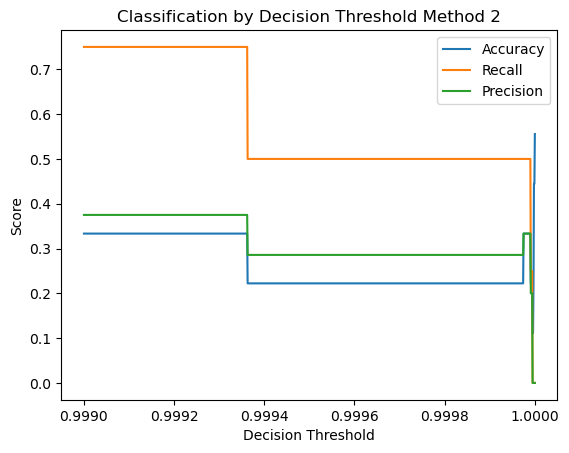

In [214]:
sns.lineplot(x = thresh, y = acc, label = 'Accuracy')
sns.lineplot(x = thresh, y = rec, label = 'Recall')
sns.lineplot(x = thresh, y = pre, label = 'Precision')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Classification by Decision Threshold Method 2')
plt.show()

In [215]:
print(accuracy_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int)))

0.16666666666666666


In [247]:
# Find k-max probabilities by case
train_prob = [arr[0] for arr in all_probs_tr]
case_prob_train = pd.concat([pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number')['prob'].apply(lambda x: x.nlargest(25).mean()).reset_index(),df_train.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
test_prob = [arr[0] for arr in all_probs_tst]
case_prob_tst = pd.concat([pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number')['prob'].apply(lambda x: x.nlargest(25).mean()).reset_index(),df_test.groupby('case_number')['label'].mean().reset_index()], axis=1).iloc[:,[0,1,3]]
case_prob_train

,case_number,prob,label
0,1,0.999869,1.0
1,2,0.999948,0.0
2,3,0.999510,1.0
3,34,0.999969,0.0
4,49,0.994365,1.0
5,53,0.999971,0.0
6,55,0.999075,1.0
7,78,0.993264,0.0
8,85,0.999959,0.0


In [257]:
# Train decision threshold for k-max probabilities by case
acc, rec, pre, thresh = [], [], [], []
for t in np.arange(0.99,1,0.00001):
    acc.append(accuracy_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    rec.append(recall_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    pre.append(precision_score(case_prob_train.label, (case_prob_train.prob > t).astype(int)))
    thresh.append(t)
print(thresh[acc.index(max(acc))])

0.9932699999999851


C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


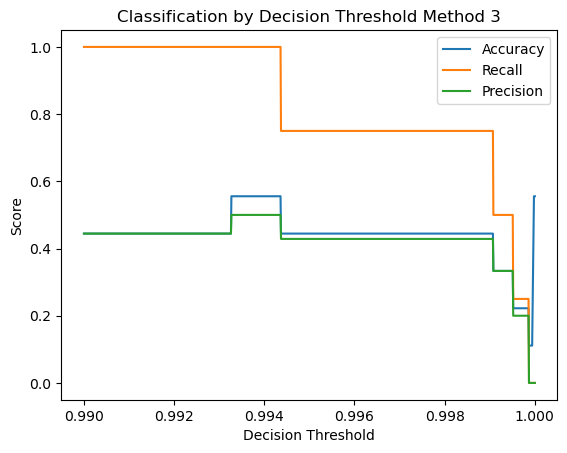

In [258]:
sns.lineplot(x = thresh, y = acc, label = 'Accuracy')
sns.lineplot(x = thresh, y = rec, label = 'Recall')
sns.lineplot(x = thresh, y = pre, label = 'Precision')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Classification by Decision Threshold Method 3')
plt.show()

In [225]:
print(accuracy_score(case_prob_tst.label,(case_prob_tst.prob > thresh[acc.index(max(acc))]).astype(int)))

0.16666666666666666


In [235]:
# Produce dataframe of top k probabilities for support-vector classifier
top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False).apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()
top_k_prob

C:\Users\akhil\AppData\Local\Temp\ipykernel_3716\925388218.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False).apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)


rank,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
case_number,,,,,,,,,,,,,,,,,,,,,
1,0.999995,0.999994,0.999993,0.999973,0.999955,0.999952,0.999948,0.999948,0.999943,0.999928,...,0.999854,0.999847,0.999833,0.999832,0.999807,0.999733,0.999716,0.999704,0.999703,0.999636
2,0.999997,0.999995,0.999995,0.999994,0.999989,0.999986,0.999986,0.999982,0.999974,0.999972,...,0.999942,0.999941,0.999934,0.999916,0.999891,0.999887,0.999882,0.999880,0.999879,0.999875
3,0.999990,0.999989,0.999982,0.999981,0.999978,0.999971,0.999970,0.999969,0.999948,0.999945,...,0.999808,0.999736,0.999707,0.999704,0.999197,0.999192,0.999108,0.997798,0.997373,0.996933
34,0.999998,0.999997,0.999997,0.999995,0.999994,0.999993,0.999992,0.999992,0.999991,0.999989,...,0.999968,0.999966,0.999962,0.999959,0.999958,0.999940,0.999923,0.999915,0.999913,0.999910
53,1.000000,0.999998,0.999997,0.999996,0.999995,0.999995,0.999993,0.999991,0.999989,0.999979,...,0.999959,0.999957,0.999955,0.999954,0.999949,0.999948,0.999948,0.999947,0.999945,0.999944
85,0.999998,0.999997,0.999994,0.999994,0.999994,0.999991,0.999990,0.999986,0.999985,0.999982,...,0.999950,0.999950,0.999933,0.999932,0.999930,0.999927,0.999923,0.999910,0.999899,0.999897


In [237]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(top_k_prob, case_label)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [239]:
accuracy_score(svc.predict(top_k_prob), case_label)

1.0

In [241]:
top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False).apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

C:\Users\akhil\AppData\Local\Temp\ipykernel_3716\1161133933.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False).apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)


In [245]:
pd.DataFrame(case_label_tst)

,label
case_number,
9,1.0
38,1.0
79,0.0


In [243]:
svc.predict(top_k_prob_tst)

array([1., 1., 1.])